# Lab 2: Sequence Modeling

In this lab we will implement two methods of sequence modeling in NLP (and other applications). The methods differ radically but they have their merits.  
The **Viterbi algorithm** for sequence modeling with a **Hidden Markov Model** recovers the most likely sequence underlying the input sequence, and while doing so it uses dynamic programming to find the optimal solution in an efficient way.  
Recurrent Neural Networks were and are a simple and common deep learning approach for sequence modeling.
They employ embeddings to represent words as vectors in a multidimensional space.  
Let's dive into them...    

# Rules

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life).
Additionally, please follow these rules when submitting the notebook:

* Put all code in the cell with the `# YOUR CODE HERE` comment.
* For theoretical questions, put your solution in the `YOUR ANSWER HERE` or `ANSWER UNDER THIS LINE` cells (and keep the header if any).
* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `# TEST...` or edit their code cells. The test cells are for sanity checking. Passing them doesn't necessarily mean that your code is fine.
* Don't change the names of provided functions and variables or arguments of the functions.
* Don't clear the output of your code cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading. You can have print() in the code, but comment them out before submitting the notebook.
* Delete those cells that you inserted for your own debugging/testing purposes.
* Don't forget to fill in the **contribution information**.
* Don't forget to fill in the **work description section** per exercise.
* Test your code and **make sure we can run your notebook** in the colab environment.
* A single notebook file (without archiving) per group should be submitted via BB.

<font color="red">Following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>  

# <font color="red">Contributions</font>

~~Delete this text and write instead of it yours:~~
* ~~a list of group members' names (NOT student IDs)~~
* ~~who contributed to which exercises and how. Note that it is important that each member has some contribution to each exercise, e.g., at least reviewing the solutions.~~

YOUR ANSWER HERE [30-50 words]

Group members:
- Diego Farinella
- Francesca Bernasconi
- Jeroen Rietveld

Each group member contributed to each exercise by co-writing the code with the others. Additionally, each member reviewed the exercises individually and eventually checked bugs or shortcomings.

Some members contributed in a grater extent in some exercises:
- Ex 1: Francesca
- Ex 2.2: Jeroen
- Ex 2.4: Diego

# General instructions

Before diving into the exercises, keep in mind that the variables defined previously can be reused in the subsequent cells. So there is no need to redefine the same variable in multiple sections, e.g., it is sufficient to read the file in a variable once and later reuse the value of the variable, instead of re-reading the file.   

If your code is too long and uses several code cells instead of a single code cell, rethink how to organize data in variables so that you can easily access the required info. Reading about [list comprehension](https://realpython.com/list-comprehension-python/#leverage-list-comprehensions) can be useful.

Your code will often be evaluated based on its behaviour. So, during the grading some code cells are executed. If code runtime is too long than expected, this will hinder grading.

<font color="red">**The cases similar to the above-mentioned ones will be subject to penalty points.**</font>

<font color="red">**Pay attention to test units**</font> that are either provided as assert cases or as comments. Test units help you by giving you a hint about the correct answer. Note that **passing test units doesn't guarantee the full points** for an exercise because test units are incomplete, and the code might fail on other test units.

# Part 1: Hidden Markov Model

In this exercise, you will implement a **Hidden Markov Model (HMM)**. HMMs specify a **joint** probability over **observations** and **hidden states**.

This is what we will do:

1. **Estimate** a simple HMM model from training data (supervised learning)
2. Find the *best* sequence of hidden states for a given sequence of observations (we define "best" in 2 different ways!)

## Setup

In [ ]:
# Import modules
%matplotlib inline
import numpy as np
from collections import defaultdict, namedtuple

## Notation

$ \Sigma := \{ o_1, \dots, o_J \} $ is our set of **observations**

$\Lambda := \{s_1, \dots, s_K \}$ is our set of **state labels**

$\Sigma^*$ are **all possible sequences** of observations (including empty string $\epsilon$)

$\Lambda^*$ all possible sequences of hidden states (including empty string $\epsilon$)

> Extra info: we can say that $\Sigma^*$ is the [Kleene-closure](https://en.wikipedia.org/wiki/Kleene_star) of $\Sigma$, and $\Lambda^*$ the Kleene-closure of $\Lambda$.

## A simple example: The Baby HMM

We start with a simple example, so that we can easily verify that our code is correct.

Consider that we are modeling how a baby behaves. We observe the baby doing the following things: laughing (`laugh`), crying (`cry`), and sleeping (`sleep`). This is our set $\Sigma$ of **observations**.

We presume that, at any moment, the baby can be either `hungry`, `bored`, or `happy`. Since babies cannot talk, each of these states is hidden. This is our set $\Lambda$ of **hidden states**.

**Now the question is: if we have a series of observations, can we predict what hidden states the baby went through?**

To tackle this problem, we assume that the baby behaves like a **1st order discrete Markov chain**: the baby's current state only depends on its previous hidden state. The baby can be described as an HMM. (Yay!)

For example, assume we observed the baby doing the following:

```
sleep cry laugh cry
cry cry laugh sleep
```

We will use these sequences as our **test set**. We can try to find out the states of the baby for those observations.

Now, to train our model, we will need some examples of **observations** and **states**; this is our **training set**:

```
laugh/happy cry/bored cry/hungry sleep/happy
cry/bored laugh/happy cry/happy sleep/bored
cry/hungry cry/bored sleep/happy
```

So we have **pairs** observation/state.

In [ ]:
# read in test data
test_data = """sleep cry laugh cry
cry cry laugh sleep"""

def test_reader(test_lines):
    for line in test_lines.splitlines():
        yield line.split()

TEST_SET = list(test_reader(test_data))

# read in train data
train_data = """laugh/happy cry/bored cry/hungry sleep/happy
cry/bored laugh/happy cry/happy sleep/bored
cry/hungry cry/bored sleep/happy"""

# for convenience, we define a Observation-State pair class
# fyi, more about namedtuple:
# https://docs.python.org/3/library/collections.html#collections.namedtuple
Pair = namedtuple("Pair", ["obs", "state"])
Pair.__repr__ = lambda x: x.obs + "/" + x.state

def train_reader(train_lines):
    for line in train_data.splitlines():
        # a pair is a string "observation/state" so we need to split on the "/"
        yield [Pair(*pair.split("/")) for pair in line.split()]

TRAIN_SET = list(train_reader(train_data))

# print the results
print("test set (observations):")
for seq in TEST_SET:
    print(seq)
print("\ntraining set (observation/state pairs):")
for seq in TRAIN_SET:
    print(seq)

test set (observations):
['sleep', 'cry', 'laugh', 'cry']
['cry', 'cry', 'laugh', 'sleep']

training set (observation/state pairs):
[laugh/happy, cry/bored, cry/hungry, sleep/happy]
[cry/bored, laugh/happy, cry/happy, sleep/bored]
[cry/hungry, cry/bored, sleep/happy]


## Vocabularies

The `numpy` library is very practical when working with numeric vectors and matrices. Examples in this notebook heavily uses numpy arrays. It is recommended that you understand how simple arithmetic operation work on the arrays. You can also find very useful methods like `max` or `argmax` that will save several lines of code. You might find the following links useful: [NumPy Reference](https://numpy.org/doc/stable/reference/), [NumPy cheatsheets](https://blog.finxter.com/collection-10-best-numpy-cheat-sheets-every-python-coder-must-own/)

It's going to be very useful if we can map states and observations to integers, so that we can identify them by a number. If we don't do this, then our implementation will be longer and much slower (This is relevant when we work with larger data, e.g. for POS tagging).

Make sure you understand what is going on here: every time we look up an observation or state, the `defaultdict` will create a new key (index) if it has not seen that key (state or observation) before.

In [ ]:
# create mappings from state/obs to an ID
STATE2INDX = defaultdict(lambda: len(STATE2INDX))
OBS2INDX = defaultdict(lambda: len(OBS2INDX))

for seq in TRAIN_SET:
    for example in seq:
        _ = STATE2INDX[example.state]
        _ = OBS2INDX[example.obs]

# convert defaultdict to normal dict to avoid their accidental modification
STATE2INDX, OBS2INDX = dict(STATE2INDX), dict(OBS2INDX)

print("\nOur vocabularies:")
print(STATE2INDX)
print(OBS2INDX)


Our vocabularies:
{'happy': 0, 'bored': 1, 'hungry': 2}
{'laugh': 0, 'cry': 1, 'sleep': 2}


The HMM for the first training set sequence looks like this:

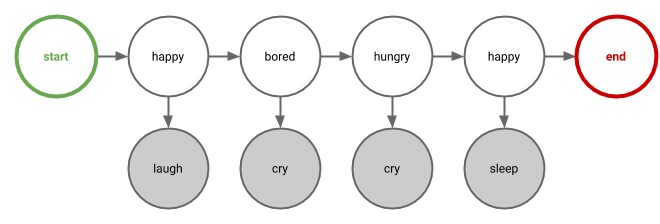

Now, we will **estimate** the following probability distributions:

- initial: $P( s_k \,|\, \texttt{start})$
- transition: $P( s_k \,|\, s_l )$
- final: $P(\texttt{stop} \,|\, s_k )$
- emission: $P( o_l \,|\, s_k)$

These distributions are all we need. Remember that:

- the probability of transitioning to a state $s_k$ only depends on one previous state $s_l$ (1st order Markov assumption).
- emitting an observation $o_l$ only depends on the state $s_k$.

## Finding the Maximum Likelihood Parameters

Now we would like to know what those distributions look like from our data. This is called **estimation**. Given our training data, we count how many times each event occurs and normalize the counts to form proper probability distributions.

Let's first do counts for the start probabilities:

In [ ]:
# we can get the number of states and observations from our dictionaries
num_states = len(STATE2INDX)
num_observations = len(OBS2INDX)

# this creates a vector of length `num_states` filled with zeros
counts_start = np.zeros(num_states)

# now we count 1 every time a sequence starts with a certain state
# we look up the index for the state that we want to count using the `STATE2INDX` dictionary
for seq in TRAIN_SET:
    counts_start[STATE2INDX[seq[0].state]] += 1.

print(counts_start)

[1. 1. 1.]


We see each state once at the beginning of a sequence in the training set, so that is why we have a count of 1 for each of them.

We now **normalize** those counts, so that we obtain a probability distribution:

In [ ]:
# since p_start is a numpy object, we can call sum on it; easy!
total = counts_start.sum()

# normalize: divide each count by the total
p_start = counts_start / total
print(f"start --> {p_start}")

start --> [0.33333333 0.33333333 0.33333333]


We now turn to the **transition probabilities** and **stop probabilities**. We count, and then we normalize:

In [ ]:
# we can transition from any state to any other state in principle,
# so we create a matrix filled with zeros so that we can count any pair of states
# in practice, some transitions might not occur in the training data
counts_trans = np.zeros((num_states, num_states))

# for the final/stop probabilities, we only need to store `num_states` values.
# so we use a vector
counts_stop = np.zeros(num_states)

# now we count transitions, one sequence at a time
for seq in TRAIN_SET:
    for i in range(1, len(seq)):

        # convert the states to indexes
        prev_state = STATE2INDX[seq[i-1].state]
        current_state = STATE2INDX[seq[i].state]

        # count
        counts_trans[current_state, prev_state] += 1.
        # note that the order of states/indices in this matrix
        # follows conditional probability order p(q_i|q_{i-1})
        # not the transition matrix A_{i-1}_{i}

# count final states
for seq in TRAIN_SET:
    state = STATE2INDX[seq[-1].state]
    counts_stop[state] += 1.

# print the counts
print("Transition counts:")
print(counts_trans)

print("Final counts:")
print(counts_stop)

Transition counts:
[[1. 2. 1.]
 [2. 0. 1.]
 [0. 1. 0.]]
Final counts:
[2. 1. 0.]


Now we can normalize again. We will need to collect the total counts per state.
Take some time to understand that the totals consist of the transition counts AND the final counts.

In [ ]:
# Useful trick: np.sum(m, 0) sums matrix m along the first dimension (with index 0).
# Note that after summing, the dimension disappears
print(counts_trans.sum(0))

[3. 3. 2.]


In [ ]:
total_per_state = counts_trans.sum(0) + counts_stop
print(f"Total counts per state:\n{total_per_state}\n")

# now we normalize
# here '/' works one column at a time in the matrix
p_trans = counts_trans / total_per_state
print(f"Transition probabilities:\n{p_trans}\n")

# here '/' divides the values in each corresponding index in the 2 vectors
p_stop = counts_stop / total_per_state
print(f"Final probabilities:\n{p_stop}\n")

Total counts per state:
[5. 4. 2.]

Transition probabilities:
[[0.2  0.5  0.5 ]
 [0.4  0.   0.5 ]
 [0.   0.25 0.  ]]

Final probabilities:
[0.4  0.25 0.  ]



**So far so good!** Now let's take care of **emission probabilities**.

In [ ]:
# now we create a matrix to keep track of emission counts
# in principle any states can emit any observation
# so we need a matrix again:
# 1st dimension is for observations, 2nd is for states
# the dim. order follows conditional probabilities p(o|s)
counts_emiss = np.zeros((num_observations, num_states))

# count
for seq in TRAIN_SET:
    for obs, state in seq:
        obs = OBS2INDX[obs]
        state = STATE2INDX[state]
        counts_emiss[obs][state] += 1.

# normalize
p_emiss = counts_emiss / counts_emiss.sum(0)

print(f"emission counts:\n{counts_emiss}\n")
print(f"p_emiss:\n{p_emiss}\n")

emission counts:
[[2. 0. 0.]
 [1. 3. 2.]
 [2. 1. 0.]]

p_emiss:
[[0.4  0.   0.  ]
 [0.2  0.75 1.  ]
 [0.4  0.25 0.  ]]



This is a good moment for a sanity check. First, take a look at the training set to see if these probabilities are correct, i.e. check if  for each state $s_k$: $$\sum_l P(s_l \,|\, s_k) = 1.0$$ Note that this includes transitions to "stop" state, so you have to take those into account.

## Decoding a sequence

Ok, so we have estimated a model. Great. Now what? Well, now we can **decode**!

Given an observation sequence $o_1, o_2, \dots, o_N$, we want to find the sequence of hidden states $s^* = s^*_1, s^*_2, \dots, s^*_N$ that **best** explains those observations.

But what does "best" mean?

1. If we are interested in the best **global** assignment of states to the sequence as a whole, we can use the **Viterbi** algorithm.
2. If we care more about minimizing the **local** error of getting each $s_i$ right, we can use **posterior decoding** (also called *max marginal decoding*).


### Decoding: The Viterbi Algorithm

Viterbi gives us the best global hidden state sequence, i.e.:

$$ \begin{array}{lll}
s^* &=& \arg\max_{s = s_1, s_2, \dots, s_N} P(s_1, s_2, \dots, s_N \,|\, o_1, o_2, \dots, o_N ) \\
    &=& \arg\max_{s = s_1, s_2, \dots, s_N} P(s_1, s_2, \dots, s_N, o_1, o_2, \dots, o_N )
\end{array}$$

To explain Viterbi we will make use of a **trellis**, a kind of graph that shows us the possible states for each time step.

For our earlier example, the trellis looks like this:

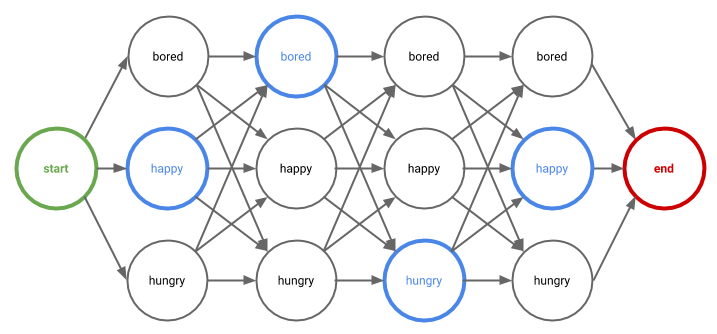

Note, that we can now label the edges of this trellis with the following probabilities:

- $P_{\text start}(s_k \,|\, \text{start})$ on the three edges from "start"
- $P_{\text stop}(\text{stop} \,|\, s_k)$ on the three edges leading to "stop"
- $P_{\text trans}(s_k \,|\, s_{l})$ on each remaining edge from state $s_l$ to $s_k$
- $P_{\text emiss}(o \,|\, s_k)$ from each state $s_k$, to an observation $o$ made from that state (not shown here)

Do you see that our trellis nicely shows the independence assumptions of the HMM?

### A Naive approach to get the best sequence

To see why the Viterbi algorithm is so useful, we can consider another way to calculate $s^*$:

- Iterate over all possible state sequences (all ways to go from `start` to `stop`)
    - Calculate the probability for that sequence
    - Store the highest probability seen so far and its sequence
- Return the sequence that had the maximum probability

The problem with this approach is that there are a lot of possible sequences!

## The Viterbi algorithm

*We use a slightly different notation here compared to the lecture.*

So how do we find the path with the highest score? The idea is that we can use our trellis to represent an **exponential number of paths**. Since we are only interested in the highest-scoring path, for every state at every time step, we only need to keep track of the **highest** probability that can lead us to that state. We can disregard any other paths that lead to that state, since they will for sure not be part of the highest-scoring path.

Viterbi uses **dynamic programming**. Here, that means that we will re-use probabilities that we have already computed, so we never have to compute the score for the same sub-problem multiple times.

Let's start at the beginning.

For the first time step, the **viterbi score** is the transition probability of reaching a state $s_k$ from "start", times the probability of emitting the first observation $o_1$ from that state:

$$\text{viterbi}(1, s_k) = P_{\text start}( s_k \,|\, \text{start}) \times P_{\text emiss}(o_1 \,|\, s_k)$$

So, the Viterbi trellis represents the path with maximum probability in position $i$ when we are in state $y_i$ having observed $o_1, o_2, \dots, o_i$, the observations up to and including that point.

Now that we have the viterbi scores for all states of the first time step in our trellis, we can use the following **recursive formula** to get the scores for all other states, one time step at a time:

$$\text{viterbi}(i, s_k) = \big( \max_{s_l \in \Lambda} P_{\text trans}(s_k | s_l) \times \text{viterbi}(i-1, s_l) \big) \times P_{\text emiss}(o_i \,|\, s_k)$$

Finally, for our final state "stop" we need to do something special, since there is no observation there:

$$\text{viterbi}(N+1, \text{stop}) = \max_{s_l \in \Lambda} P_{\text stop}(\text{stop} \,|\, s_l) \times \text{viterbi}(i-1, s_l)  $$

This is all we need to know what probability the highest scoring path has! Do you see how the dynamic programming helps us to solve this task efficiently?

## How did we get here?

Once we reach the "stop" state we know the maximum probability, but we forgot how we got there! If you don't see this immediately, remember that, whenever we computed the viterbi score for a state, we took the maximum over all previous states' viterbi scores, times the transition from those states. But we didn't keep track of which state was actually selected in that "max" operation. So now that we are in "stop", we don't know how we got there.

To solve this, we will use **backpointers**. Whenever we do a $\max$, we store what state was selected by that max (i.e. the $\arg\max$):

$$\text{backtrack}(i, s_k) = \arg\max_{s_l \in \Lambda} P_{\text trans}(s_k | s_l) \times \text{viterbi}(i-1, s_l)$$


## From probabilities to log-probabilities

Now you know enough to implement Viterbi! But before we start...  
Because probabilities tend to get rather small when multiplying, causing numerical instabilities, we will use **log probabilities**. This means that, instead of multiplying, we can now **sum** probabilities, because:

$$ \log(uv) = \log u + \log v$$

To get the probability of a  path trough our trellis from "start" to "stop", we can just **sum** the log-probabilities that we encounter. So, finding the best ("Viterbi") path means finding the path with the **highest score**.

In [ ]:
def convert_to_log(p_start=None, p_trans=None, p_stop=None, p_emiss=None):
    """
    Convert all probabilities to log-probabilities
    """
    return np.log(p_start), np.log(p_trans), np.log(p_stop), np.log(p_emiss)

print(f"Before:\n{p_start}\n{p_trans}\n{p_stop}\n{p_emiss}")

# do the conversion
lp_start, lp_trans, lp_stop, lp_emiss = \
    convert_to_log(p_start=p_start, p_trans=p_trans, p_stop=p_stop, p_emiss=p_emiss)

print(f"After:\n{lp_start}\n{lp_trans}\n{lp_stop}\n{lp_emiss}")

Before:
[0.33333333 0.33333333 0.33333333]
[[0.2  0.5  0.5 ]
 [0.4  0.   0.5 ]
 [0.   0.25 0.  ]]
[0.4  0.25 0.  ]
[[0.4  0.   0.  ]
 [0.2  0.75 1.  ]
 [0.4  0.25 0.  ]]
After:
[-1.09861229 -1.09861229 -1.09861229]
[[-1.60943791 -0.69314718 -0.69314718]
 [-0.91629073        -inf -0.69314718]
 [       -inf -1.38629436        -inf]]
[-0.91629073 -1.38629436        -inf]
[[-0.91629073        -inf        -inf]
 [-1.60943791 -0.28768207  0.        ]
 [-0.91629073 -1.38629436        -inf]]


<ipython-input-10-77e2f4085654>:5: RuntimeWarning: divide by zero encountered in log
  return np.log(p_start), np.log(p_trans), np.log(p_stop), np.log(p_emiss)


## Smoothing

Some probabilities were 0.0, and the log function is not defined for zero, resulting in a **warning** or `-inf` (depending on your numpy version).

To prevent this, we can add a small **smoothing** value to our **counts**, so that we never have a probability of zero.

To make things easier, we define a `normalize_all` function below that does all the normalization again,
but now adding a small value to all the counts.

In [ ]:
def normalize(x, smoothing=0.1, axis=0):
    smoothed = x + smoothing
    return smoothed / smoothed.sum(axis)

def normalize_all(counts_start, counts_trans, counts_stop, counts_emiss, smoothing=0.1):
    """Normalize all counts to probabilities, optionally with smoothing."""
    p_start = normalize(counts_start, smoothing=smoothing)
    p_emiss = normalize(counts_emiss, smoothing=smoothing)

    counts_trans_smoothed = counts_trans + smoothing
    counts_stop_smoothed = counts_stop + smoothing
    total_trans_stop = counts_trans_smoothed.sum(0) + counts_stop_smoothed
    p_trans = counts_trans_smoothed / total_trans_stop
    p_stop = counts_stop_smoothed / total_trans_stop

    return p_start, p_trans, p_stop, p_emiss


# normalize with smoothing
smoothing = 0.1
p_start, p_trans, p_stop, p_emiss = normalize_all(
    counts_start, counts_trans, counts_stop, counts_emiss, smoothing=smoothing)

In [ ]:
# convert to log-probabilities
print(f"Smoothed probabilities:\n{p_start}\n{p_trans}\n{p_stop}\n{p_emiss}")

lp_start, lp_trans, lp_stop, lp_emiss = convert_to_log(p_start=p_start, p_trans=p_trans, p_stop=p_stop, p_emiss=p_emiss)
print(f"Smoothed log-probabilities:\n{lp_start}\n{lp_trans}\n{lp_stop}\n{lp_emiss}")

Smoothed probabilities:
[0.33333333 0.33333333 0.33333333]
[[0.2037037  0.47727273 0.45833333]
 [0.38888889 0.02272727 0.45833333]
 [0.01851852 0.25       0.04166667]]
[0.38888889 0.25       0.04166667]
[[0.39622642 0.02325581 0.04347826]
 [0.20754717 0.72093023 0.91304348]
 [0.39622642 0.25581395 0.04347826]]
Smoothed log-probabilities:
[-1.09861229 -1.09861229 -1.09861229]
[[-1.59108877 -0.7396672  -0.78015856]
 [-0.94446161 -3.78418963 -0.78015856]
 [-3.98898405 -1.38629436 -3.17805383]]
[-0.94446161 -1.38629436 -3.17805383]
[[-0.92576948 -3.76120012 -3.13549422]
 [-1.57239664 -0.32721291 -0.09097178]
 [-0.92576948 -1.36330484 -3.13549422]]


## Ex1 [24pt] Implement the Viterbi algorithm

You will now implement the Viterbi algorithm. Complete the function `viterbi(sequence, lp_start, lp_trans, lp_emiss, lp_stop)` below.

**Input:** sequence ($o_1, ..., o_N$), $P_\text{start}$, $P_\text{trans}$, $P_\text{emiss}$, $P_\text{stop}$

*Forward pass: compute the best path for every end state*

- set $\text{viterbi}(1, s_k)$ for each $s_k$
- for $i=2$ to $N$, and for each $s_k$, set $\text{viterbi}(i, s_k$) and $\text{backtrack}(i, s_k)$
- $\text{max_prob} = \max_{s_l} P_{\text{stop}}(\text{stop} \,|\, s_l) \times viterbi(N, s_l)$

*Backward pass: backtrack to get most likely path*
- $\hat{s}_N = \arg\max_{s_l} P_\text{stop}(\text{stop} \,|\, s_l) \times viterbi(N, s_l)$
- for $i = N-1$ to $1$: $\hat{s}_i = \text{backtrack}(i+1, \hat{s}_{i+1})$

**Output:** max_prob, Viterbi path $\hat{s}_1, \hat{s}_2, \dots, \hat{s}_N$

<font color="red">**You a free to re-use global variables, such as `OBS2INDX` or `STATE2INDX`, if needed, in the body of the function, instead of redefining them.**</font>

<font color="red">**It is mandatory to use numpy array operations where possible, instead of treating arrays as lists.**</font>  The latter will lead to an inefficient use of numpy array and a lengthy code.

In [ ]:
print("lp_emiss:", lp_emiss)
print("lp_trans:", lp_trans)
print("lp_start:", lp_start)
print("lp_stop:", lp_stop)

lp_emiss: [[-0.92576948 -3.76120012 -3.13549422]
 [-1.57239664 -0.32721291 -0.09097178]
 [-0.92576948 -1.36330484 -3.13549422]]
lp_trans: [[-1.59108877 -0.7396672  -0.78015856]
 [-0.94446161 -3.78418963 -0.78015856]
 [-3.98898405 -1.38629436 -3.17805383]]
lp_start: [-1.09861229 -1.09861229 -1.09861229]
lp_stop: [-0.94446161 -1.38629436 -3.17805383]


In [ ]:
def viterbi(sequence, lp_start=None, lp_trans=None, lp_stop=None, lp_emiss=None):
    """
    Compute the Viterbi sequence.
    Note: you have to use log-probabilities!

    Return:
      - best_score (float) the log-probability of the best path
      - best_path (int list) the best path as a list of state IDs
      - trellis (float array) the trellis
    """

    length = len(sequence)
    num_states = len(lp_start)

    # trellis to store Viterbi scores
    # we store -inf as our initial scores since log(0)=-inf
    trellis = np.full([length, num_states], -np.inf)

    # backpointers to backtrack (to remember what prev. state caused the maximum score)
    # we initialize with -1 values, to represent a non-existing index
    backpointers = -np.ones([length, num_states], dtype=int)

    # YOUR CODE HERE

    # Set the trelli for the first obs
    obs_idx = OBS2INDX[sequence[0]]
    trellis[0, :] = lp_start + lp_emiss[obs_idx, :]

    # Then, for all the others and the final
    for t in range(1, length):
        obs_idx = OBS2INDX[sequence[t]]

        for s in range(num_states):
          scores = trellis[t-1, :] + lp_trans[s, :] + lp_emiss[obs_idx, s]
          best_prev_state = np.argmax(scores)
          trellis[t, s] = scores[best_prev_state]
          backpointers[t, s] = best_prev_state

    final_scores = trellis[length-1, :] + lp_stop

    # Compute the best final score and find the best path
    best_final_state = np.argmax(final_scores)
    best_score = final_scores[best_final_state]

    best_path = np.zeros(length, dtype=int)
    best_path[length-1] = best_final_state

    # Backtracking
    for t in range(length-1, 0, -1):
      best_path[t-1] = backpointers[t, best_path[t]]

    return best_score, best_path, trellis

## Trying out Viterbi

Once you have implemented the Viterbi algorithm, try it out on the following sequence.

In [ ]:
# TEST 1.1
# Test out your Viterbi-algorithm here

test_sequence = TEST_SET[0]
best_score, best_path, _ = viterbi(test_sequence, lp_start=lp_start, lp_trans=lp_trans, lp_stop=lp_stop, lp_emiss=lp_emiss)

print("observation=", test_sequence)
print(best_score)
print("best state sequence=", best_path)

i2state = {v : k for k, v in STATE2INDX.items()}
print([i2state[i] for i in best_path])

observation= ['sleep', 'cry', 'laugh', 'cry']
-7.619461837738772
best state sequence= [0 1 0 1]
['happy', 'bored', 'happy', 'bored']


## Work description for Ex1

~~Describe your approach to solving the exercises, for example, what steps you took first, followed by subsequent actions, which parts you found most challenging or easy, any specific helpful assistance received from TAs, whether you used GenAI, to what extent, at what stage, which one, how helpful was it, etc.~~

YOUR ANSWER HERE [100-200 words]

Before writing the code of this exercise, we took time to understand the Viterbi algorithm. We began by watching an explanatory video that showed how the algorithm works and it helped us understand the key concepts. We had to understand how to represent and compute the trellis, making sure that it was correctly initialised and updated at each step. We also had to be careful about the correct use of indexing and log-probabilities.
We implemented the algorithm step by step, starting from the first observation and then iterating through the sequence until the final state.
The TA helped us by clarifying some details and helped us decide on the best way to handle some calculations. GenAI was used to review the code.

# Part 2: POS tagging with LSTM

In the 2nd part, we will play with training a recurrent model for part of speech tagging. We start with implementing the evaluation and training procedures for LSTM-based tagger. Initially we will work on the toy data so that you understand the procedures. Later we use the Brown corpus with Universal POS tags. We will train a tagger on the data and analyse the training dynamics. Then we will use pre-trained word embeddings to initialize an LSTM. We will experiment with training taggers with and without pre-trained word vectors.

## Setup

In [ ]:
import random, math
import nltk
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# if any cell errors with "A UTF-8 locale is required. Got ANSI_X3.4-1968"
# uncomment and run the next two lines
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# torch-specific code
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
print(f"NLTK version: {nltk.__version__}")
print(f"torch version: {torch.__version__}")

NLTK version: 3.9.1
torch version: 2.6.0+cu124


In [ ]:
# download several data incorporated in NLTK
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('wordnet')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Some auxiliary functions that will be reused throughout the notebook

def plot_numbers(num_listm, xlabel="Epochs", ylabel="Loss", label=None):
    """ Visualizes a list of numbers as a line plot
    """
    plt.plot(np.arange(len(num_listm)), num_listm, 'o-', markersize=2, label=label)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if label: plt.legend()

# Let's plot the loss values and see how training on more epochs decreases the loss value
def plot_results(res, parts=("train", "valid"), metrics=("loss", "acc"), title=None):
    """ Shorthand for contrasting loss and accuracy numbers obtained on different datasets
    """
    for m in metrics:
        for p in parts:
            plot_numbers(res[p][m], label=f"{p} {m}", ylabel=m)
        if title: plt.title(title)
        plt.show()

def train_validation_split(sequence, train_ratio, valid_ratio, seed=0, seperate_tags=False):
    """ returns two non-overlapping subpart of the input sequence.
        The sizes of the parts satisfy the size ration constraint.
        If seperate_tags is on, this means the input has format of [(w1,pos1), (w2,pos2)]
        and it will be converted to [(w1,w2), (pos1,pos2)]
    """
    assert train_ratio + valid_ratio <= 1
    population = list(sequence)
    n = len(population)
    train_num, valid_num = math.floor(n * train_ratio), math.floor(n * valid_ratio)
    random.seed(seed)
    data = random.sample(population, train_num + valid_num)
    if seperate_tags:
        data = [ list(zip(*sent)) for sent in data ]
    return data[:train_num], data[train_num:]

## LSTM tagger

Read the [pytorch tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) on sequence tagging with LSTM. It is very important that you practice how to read and understand the tutorials on web. Not all tutorials are written in a clear way, and understanding the overlooked parts requires practice and effort.
Fortunately, the aforementioned tutorial is very well written. Though it uses many new operations related to tensors (=a multi-dimensional matrix containing elements of a single data type).

Pytorch is well documented and almost any function, method, or class can be looked up [here](https://pytorch.org/docs/stable/index.html), in the top-left corner. For example, `torch.randn` is defined [here](https://pytorch.org/docs/stable/generated/torch.randn.html#torch.randn). Note that keywords in the code of the tutorial are hyperlinks with links to the corresponding documentation.

The code below is copied from the tutorial page as we will reuse certain variables and functions. We only renamed the data variable name to indicate that it is toy data.

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


toy_training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in toy_training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


The code below is also copied from the tutorial but it incorporates two additions:

1.   Fixing the torch's random generator seeds: see `nn_seed` and `em_seed`. These seeds control the initialization of `self.word_embeddings` from [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding) and `self.lstm` from [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM). In the first case, the `vocab_size` number of `embedding_dim`-dimensional tensors are generated, while in the second case the LSTM network is initialized with random weights (note that `self.hidden2tag` is also randomized weights denoting `V` matrix, from J&M chapter 8, that is used to obtain output from the hidden layer for each time step). We make the LSTM initialization based on the seed to maintain replicability of the same results.

2.   Making the class flexible to allow initialization from pre-trained word embeddings. `embedding` input can be a tuple that specifies the dimensions of the embedding layer or a ready tensor that records pre-trained word embeddings.

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding, hidden_dim, tagset_size, nn_seed=0, em_seed=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        if isinstance(embedding, torch.Tensor):
            self.word_embeddings = nn.Embedding.from_pretrained(embedding)
            embedding_dim = self.word_embeddings.weight.size(1)
        else:
            torch.manual_seed(em_seed)
            vocab_size, embedding_dim = embedding
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        torch.manual_seed(nn_seed)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Ex2.1a [8pt] Evaluation

The training (i.e. last) code in the [tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#example-an-lstm-for-part-of-speech-tagging) contains lines of code that we will reuse several times. That's why we are going to make specific functions out of them. The first function we will make takes a model and data (and other stuff) and returns predictions and metrics wrapped in a dictionary. read the function definition carefully for more details.

In [ ]:
def evaluate_tagger(model, data, w2i=None, t2i=None, get_tags=False, get_scores=False):
    """ model - an NN model, in particular an LSTMTagger object
        data - a sequence of pairs of a list of tokens and a list of POS tags
        w2i - a dict mapping words to indices, when w2i is not specified this means that
            tokens are already mapped to indices in data and no mapping is needed. This option
            will be handy when evaluating a tagger several times on a data during the training.
        t2i - a dict mapping POS tags to indices. When t2i is not specified this means that
            pos tags are already mapped to indices in data, and also when returning tags
            as an output, they won't be mapped to human readable tags, but instead returned
            as indices.
        get_tags - whether return predicted tags (i.e., most probable tag per token)
        get_scores - whether to return actual tag scores for each token
    return:
        a dictionary with keys 'loss', 'acc', 'scores', 'tags'.
        Note that the loss value is averaged across sentences: (loss_sen_1+...loss_sen_N)/N.
        The keys are present in the dictionary for certain values according to the input.
        For example, if get_tags=False, there shouldn't be 'tags' key in the dictionary.
        As an example, see the reference output below.
    """
    ### YOUR CODE HERE ###
    loss_function = nn.NLLLoss()
    model.eval() # Set the model in evaluation mode

    # If needed initializing an inverse mappings to get the tags
    if get_tags and t2i:
      i2t = {}
      for tag, index in t2i.items():
        i2t[index] = tag
    else:
      i2t = None

    total_loss = 0.0
    num_sentences = 0
    right_classifications = 0
    classifications = 0

    all_tags = []
    all_scores = []

    with torch.no_grad(): # Suggested by the tutorial

        # Preparing the inputs for the model
        for sent, tags in data:
            if w2i:
                sentence_in = prepare_sequence(sent, w2i)
            else:
                sentence_in = sent.clone().detach() if isinstance(sent, torch.Tensor) else torch.tensor(sent)

            if t2i:
                targets = prepare_sequence(tags, t2i)
            else:
                targets = tags.clone().detach() if isinstance(tags, torch.Tensor) else torch.tensor(tags)

            # Apply the model to get tag scores
            tag_scores = model(sentence_in)

            # Compute the required metrics (loss and acc)
            loss = loss_function(tag_scores, targets)
            total_loss += loss.item()
            num_sentences += 1
            labels = torch.argmax(tag_scores, dim=1) # Get the the labels with argmax
            correct = (labels == targets).sum().item()
            right_classifications += correct
            classifications += len(targets)

            # Get tags per sentence if needed
            if get_tags:
              sent_tags = []
              for idx in labels:
                if i2t:
                  sent_tags.append(i2t[idx.item()])
                else:
                  sent_tags.append(idx.item())
              all_tags.append(sent_tags)


            # Get scores per sentence if needed
            if get_scores:
                all_scores.append(tag_scores.detach().cpu())

    # Build output dict with the required results

    output = {}
    output["loss"] = total_loss / num_sentences
    output["acc"] = right_classifications / classifications
    if get_tags:
        output["tags"] = all_tags
    if get_scores:
        output["scores"] = all_scores

    return output

In [ ]:
# TEST Ex1.1
# deterministically initialize LSTM tagger and predict the tags for the data
toy_tagger = LSTMTagger((len(word_to_ix), EMBEDDING_DIM), HIDDEN_DIM, len(tag_to_ix))
# evaluate tagger
pred = evaluate_tagger(toy_tagger, toy_training_data, w2i=word_to_ix, t2i=tag_to_ix, get_tags=True, get_scores=True)
print(pred)

print("Tokens, gold tags, and predicetd most probable tag per token")
for (sent, tags1), tags2 in zip(toy_training_data, pred['tags']):
    for seq in (sent, tags1, tags2):
        print(''.join([ f"{el:^8}" for el in seq ]))

{'loss': 1.0800790786743164, 'acc': 0.5555555555555556, 'tags': [['NN', 'NN', 'DET', 'NN', 'NN'], ['NN', 'DET', 'DET', 'NN']], 'scores': [tensor([[-1.0546, -1.0076, -1.2498],
        [-1.0310, -1.0182, -1.2656],
        [-0.9870, -1.0311, -1.3069],
        [-1.1044, -0.9940, -1.2090],
        [-1.0882, -0.9960, -1.2248]]), tensor([[-1.0523, -0.9922, -1.2727],
        [-0.9906, -0.9994, -1.3451],
        [-0.9478, -1.0155, -1.3856],
        [-1.0980, -0.9716, -1.2449]])]}
Tokens, gold tags, and predicetd most probable tag per token
  The     dog     ate     the    apple  
  DET      NN      V      DET      NN   
   NN      NN     DET      NN      NN   
Everybody  read    that    book  
   NN      V      DET      NN   
   NN     DET     DET      NN   


Reference output:

```
{'loss': 1.0800790786743164, 'acc': 0.5555555555555556, 'tags': [['NN', 'NN', 'DET', 'NN', 'NN'], ['NN', 'DET', 'DET', 'NN']], 'scores': [tensor([[-1.0546, -1.0076, -1.2498],
        [-1.0310, -1.0182, -1.2656],
        [-0.9870, -1.0311, -1.3069],
        [-1.1044, -0.9940, -1.2090],
        [-1.0882, -0.9960, -1.2248]]), tensor([[-1.0523, -0.9922, -1.2727],
        [-0.9906, -0.9994, -1.3451],
        [-0.9478, -1.0155, -1.3856],
        [-1.0980, -0.9716, -1.2449]])]}
Tokens, gold tags, and predicetd most probable tag per token
  The     dog     ate     the    apple
  DET      NN      V      DET      NN
   NN      NN     DET      NN      NN
Everybody  read    that    book
   NN      V      DET      NN
   NN     DET     DET      NN
```

## Q2.1b [4pt] Explain predictions



1.   *Given the above predictions from the tagger, is there any rationale for why the tagger predicts NN often?*
2.   *What is the predicted probability distribution over the tags for "that" in the data*? In case your tagger's output is different from the reference output, make clear which output your answer is based on.



<font color="red">█████ ANSWER UNDER THIS LINE █████</font>

1. One can clearely see that the model predicts NN often compared to the other tags (6 times out of 9 predictions). Likely, this is due to the fact that NN is the most spread tag in the toy training data (it appears 4 times out of 9). This would also justify the fact that the second more common prediction  (3 times out of 9) is DET, which is the second more common tag in the training data (appearing still 3 times out of 9).

2. For the word "the", the probability distribution appears as follows. For the first tag DET: *e*-0.9478 = 0.38759279; for the second tag NN: *e*-1.0155 = 0.362221273; for the third tag V: *e*-1.3856 = 0.25017365. In short, it is sufficient to exponentiate the log-probabiities in order to get a normal probability distribution. As a sanity, check, it is easy to compute that 0.38759279 + 0.362221273 + 0.25017365 = 1.


## Ex2.2: [8pt] Training

We need to write a function that trains a model on the data. This function later will be reused for training the tagger on different training sets. Again, reuse the code from the tutorial page to complete the body of the function. *Keep the learning rate same*.
During training, the training data is isually shuffled, but here, for simplicity, *don't shuffle the data*, keep it as it is.
Note that the function has to return the list of loss and accuracy values that is one item longer than the number of epochs.
Don't forget to **reuse** `evaluate_tagger` function.
Read the function definition for more details.

**Hints**: the function presupposes training and evaluating a model on the same data several times. Make sure that you convert the data into tensors once and not for every epoch.
Feel free to define sub-functions that will be reused for train and valid parts. This will make the code less redundant.
The tqdm module gives a nice way to report the progress of training.

In [ ]:
def train_tagger(model, train, w2i, t2i, valid=None, epoch_num=10, verbose=False):
    """ model - an NN model, in particular an LSTMTagger object
        train - a sequence of pairs of a list of tokens and a list of POS tags
        w2i - a dict mapping words to indices
        t2i - a dict mapping POS tags to indices
        valid - optional validation data structurally identical to train.
            When the validation data is provided, the output also records results about it.
        epoch_num - the number of times to train the model on the train data
        verbose - a flag that makes the function print various useful info. For example,
            it can be used to turn on/off the tqdm progress bar during the training.

        return:
            a dictionary with keys 'train' and 'valid', the existence of the latter depends
            on whether the valid arg is provided. The values of the keys are dictionaries
            with keys 'loss', 'acc', 'best_acc'. The first two have a list value of length epoch_num + 1.
            This is because it includes the loss & acc of the initial model and the final too.
            Note that the loss value should be averaged across sentences: (loss_sen_1+...loss_sen_N)/N.
            'best_acc' keeps the max values from the 'acc' list.
            See the reference output below as an example.
    """
    ### YOUR CODE HERE ###

    # Function to convert data
    def convert_data_to_tensors(data, w2i, t2i):
        tensor_data = []
        for sent, tags in data:
            sentence_tensor = prepare_sequence(sent, w2i)
            targets_tensor = prepare_sequence(tags, t2i)
            tensor_data.append((sentence_tensor, targets_tensor))
        return tensor_data

    # Convert data to tensors
    train_tensors = convert_data_to_tensors(train, w2i, t2i)
    valid_tensors = None
    if valid is not None:
        valid_tensors = convert_data_to_tensors(valid, w2i, t2i)

    optimizer = optim.SGD(model.parameters(), lr=0.1)
    loss_function = nn.NLLLoss()

    result = {'train': {'loss': [], 'acc': [], 'best_acc': 0.0}}
    if valid is not None:
        result['valid'] = {'loss': [], 'acc': [], 'best_acc': 0.0}

    # Evaluate initial model (epoch 0)
    initial_train_eval = evaluate_tagger(model, train_tensors)
    result['train']['loss'].append(initial_train_eval['loss'])
    result['train']['acc'].append(initial_train_eval['acc'])
    result['train']['best_acc'] = initial_train_eval['acc']

    if valid is not None:
        initial_valid_eval = evaluate_tagger(model, valid_tensors)
        result['valid']['loss'].append(initial_valid_eval['loss'])
        result['valid']['acc'].append(initial_valid_eval['acc'])
        result['valid']['best_acc'] = initial_valid_eval['acc']

    epoch_iterator = range(epoch_num)
    if verbose:
        epoch_iterator = tqdm(epoch_iterator, desc="Training")

    # Loop to train for several epochs
    for epoch in epoch_iterator:
        model.train()

        for sentence_tensor, targets_tensor in train_tensors:
            model.zero_grad()

            tag_scores = model(sentence_tensor)

            loss = loss_function(tag_scores, targets_tensor)

            loss.backward()
            optimizer.step()

        # Evaluate on training data
        train_eval = evaluate_tagger(model, train_tensors)
        result['train']['loss'].append(train_eval['loss'])
        result['train']['acc'].append(train_eval['acc'])

        if train_eval['acc'] > result['train']['best_acc']:
            result['train']['best_acc'] = train_eval['acc']

        # Evaluate on validation data if provided
        if valid is not None:
            valid_eval = evaluate_tagger(model, valid_tensors)
            result['valid']['loss'].append(valid_eval['loss'])
            result['valid']['acc'].append(valid_eval['acc'])

            if valid_eval['acc'] > result['valid']['best_acc']:
                result['valid']['best_acc'] = valid_eval['acc']

        # Print progress if verbose
        if verbose and not hasattr(epoch_iterator, 'set_postfix'):
            print(f"Epoch {epoch+1}/{epoch_num} - Train Loss: {train_eval['loss']:.4f}, Train Acc: {train_eval['acc']:.4f}", end="")
            if valid is not None:
                print(f", Valid Loss: {valid_eval['loss']:.4f}, Valid Acc: {valid_eval['acc']:.4f}")
            else:
                print()

    return result


In [ ]:
# TEST Ex1.2-1
# defining a toy validation set
toy_validation_data = [
    ("The dog read that book".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody ate the apple".split(), ["NN", "V", "DET", "NN"])
]
# initialize the model
trained_toy_tagger = LSTMTagger((len(word_to_ix), EMBEDDING_DIM), HIDDEN_DIM, len(tag_to_ix))
# train and retrieve the loss values per epoch
res = train_tagger(trained_toy_tagger, toy_training_data, word_to_ix, tag_to_ix, valid=toy_validation_data, epoch_num=200)
print(f"results: {res}")

results: {'train': {'loss': [1.0800790786743164, 1.0762487053871155, 1.072744369506836, 1.069520890712738, 1.0665384531021118, 1.0637630820274353, 1.0611646175384521, 1.0587173104286194, 1.0563986897468567, 1.0541892051696777, 1.052071988582611, 1.0500323176383972, 1.048057198524475, 1.046135425567627, 1.0442574620246887, 1.0424144864082336, 1.0405990481376648, 1.0388041734695435, 1.0370243191719055, 1.0352540016174316, 1.0334884524345398, 1.0317234992980957, 1.029955267906189, 1.028179943561554, 1.0263945162296295, 1.0245959162712097, 1.0227813720703125, 1.0209480822086334, 1.0190935730934143, 1.0172154307365417, 1.0153114199638367, 1.0133792757987976, 1.0114168524742126, 1.0094218254089355, 1.0073922872543335, 1.0053260326385498, 1.0032211244106293, 1.0010755360126495, 0.9988869428634644, 0.9966534376144409, 0.9943730235099792, 0.9920433461666107, 0.9896624088287354, 0.9872280955314636, 0.9847381114959717, 0.9821901917457581, 0.9795820713043213, 0.9769113659858704, 0.9741758704185486

Reference output
```
results: {'train': {'loss': [1.0800790786743164, 1.0762487053871155, 1.072744369506836, 1.069520890712738, 1.0665384531021118, 1.0637630820274353, 1.0611646175384521, 1.0587173104286194, 1.0563986897468567, 1.0541892051696777, 1.052071988582611, 1.0500323176383972, 1.048057198524475, 1.0461354851722717, 1.0442574620246887, 1.0424144864082336, 1.0405990481376648, 1.0388041734695435, 1.0370243191719055, 1.0352540016174316, 1.0334884524345398, 1.0317234992980957, 1.029955267906189, 1.0281798839569092, 1.0263945162296295, 1.0245959758758545, 1.0227813720703125, 1.0209480822086334, 1.0190935730934143, 1.0172154307365417, 1.0153114199638367, 1.0133792757987976, 1.0114167928695679, 1.0094218254089355, 1.0073922872543335, 1.0053260326385498, 1.0032211244106293, 1.0010755360126495, 0.9988869428634644, 0.9966534376144409, 0.9943730235099792, 0.9920433461666107, 0.9896624088287354, 0.9872280955314636, 0.9847381114959717, 0.9821900725364685, 0.9795820713043213, 0.9769113957881927, 0.9741758704185486, 0.971373051404953, 0.968500405550003, 0.9655555188655853, 0.9625357389450073, 0.9594384133815765, 0.9562608897686005, 0.9530004262924194, 0.9496542811393738, 0.9462195336818695, 0.9426933825016022, 0.9390727579593658, 0.9353549182415009, 0.9315365552902222, 0.9276146292686462, 0.9235861897468567, 0.9194479286670685, 0.9151966571807861, 0.9108293950557709, 0.9063427448272705, 0.9017335474491119, 0.8969985246658325, 0.8921345770359039, 0.8871385455131531, 0.8820073008537292, 0.8767377138137817, 0.8713269233703613, 0.8657719492912292, 0.8600700199604034, 0.8542185723781586, 0.8482151329517365, 0.8420574069023132, 0.8357434272766113, 0.8292712569236755, 0.8226395547389984, 0.8158469200134277, 0.8088927268981934, 0.8017762303352356, 0.7944974899291992, 0.7870568335056305, 0.779455155134201, 0.7716937363147736, 0.7637743949890137, 0.7556994557380676, 0.747471958398819, 0.7390953898429871, 0.7305739521980286, 0.7219121754169464, 0.7131155133247375, 0.7041897773742676, 0.6951413750648499, 0.685977429151535, 0.6767054200172424, 0.6673334836959839, 0.657869964838028, 0.64832404255867, 0.6387049555778503, 0.6290224492549896, 0.6192863881587982, 0.6095071136951447, 0.5996948778629303, 0.5898602306842804, 0.5800137519836426, 0.5701659321784973, 0.5603272318840027, 0.5505081117153168, 0.5407186597585678, 0.5309689044952393, 0.5212685018777847, 0.5116268247365952, 0.5020530223846436, 0.49255549907684326, 0.4831426292657852, 0.47382208704948425, 0.4646011292934418, 0.455486536026001, 0.44648461043834686, 0.43760116398334503, 0.42884135246276855, 0.420210063457489, 0.4117113947868347, 0.4033491313457489, 0.3951266258955002, 0.38704653084278107, 0.379111185669899, 0.37132251262664795, 0.36368197202682495, 0.35619062185287476, 0.34884922206401825, 0.3416580855846405, 0.3346172273159027, 0.32772640883922577, 0.3209850490093231, 0.3143923729658127, 0.30794721841812134, 0.3016485273838043, 0.2954946607351303, 0.2894841134548187, 0.28361500799655914, 0.27788545936346054, 0.27229342609643936, 0.2668367102742195, 0.26151304692029953, 0.25632014125585556, 0.2512555569410324, 0.24631685763597488, 0.24150147289037704, 0.23680689930915833, 0.23223048448562622, 0.22776974737644196, 0.22342193126678467, 0.2191845253109932, 0.21505482494831085, 0.21103034913539886, 0.20710836350917816, 0.20328643918037415, 0.19956187903881073, 0.1959322690963745, 0.19239506870508194, 0.18894780427217484, 0.18558815866708755, 0.1823136806488037, 0.17912207543849945, 0.17601102590560913, 0.17297829687595367, 0.17002175748348236, 0.1671391949057579, 0.16432850062847137, 0.16158772259950638, 0.15891478210687637, 0.15630778670310974, 0.15376483649015427, 0.1512840986251831, 0.1488637775182724, 0.14650212973356247, 0.14419741183519363, 0.14194803684949875, 0.13975241407752037, 0.13760895282030106, 0.13551612943410873, 0.13347259163856506, 0.13147679716348648, 0.12952743843197823, 0.12762318551540375, 0.1257627233862877, 0.12394478917121887, 0.12216819450259209, 0.12043173983693123, 0.11873431876301765, 0.11707473546266556, 0.11545206606388092, 0.11386516317725182, 0.11231311783194542], 'acc': [0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'best_acc': 1.0}, 'valid': {'loss': [1.0846959352493286, 1.0808380246162415, 1.0773123502731323, 1.074073314666748, 1.0710812211036682, 1.0683015584945679, 1.0657045245170593, 1.0632638335227966, 1.0609570741653442, 1.0587645769119263, 1.0566694736480713, 1.0546568036079407, 1.0527135729789734, 1.050828456878662, 1.048991858959198, 1.0471948385238647, 1.0454300045967102, 1.0436905026435852, 1.0419704914093018, 1.04026460647583, 1.0385679006576538, 1.0368764400482178, 1.0351861119270325, 1.0334933400154114, 1.031795084476471, 1.0300881266593933, 1.0283698439598083, 1.0266374945640564, 1.0248886346817017, 1.0231209993362427, 1.0213320851325989, 1.0195199251174927, 1.0176822543144226, 1.015817105770111, 1.0139222741127014, 1.0119959115982056, 1.010036051273346, 1.008040428161621, 1.0060072541236877, 1.0039344429969788, 1.0018200278282166, 0.9996618628501892, 0.9974577724933624, 0.9952059388160706, 0.992904007434845, 0.9905498921871185, 0.9881412386894226, 0.9856758415699005, 0.9831514060497284, 0.9805654585361481, 0.9779156148433685, 0.975199431180954, 0.9724143147468567, 0.9695577323436737, 0.9666268825531006, 0.9636191427707672, 0.9605317711830139, 0.9573618173599243, 0.9541065096855164, 0.950762927532196, 0.9473278522491455, 0.9437984228134155, 0.940171480178833, 0.936443954706192, 0.9326125979423523, 0.9286741614341736, 0.9246255159378052, 0.9204634130001068, 0.9161844551563263, 0.9117855131626129, 0.9072633981704712, 0.9026147425174713, 0.8978364765644073, 0.8929254114627838, 0.8878785669803619, 0.8826929926872253, 0.8773658275604248, 0.8718942999839783, 0.8662759959697723, 0.8605084121227264, 0.854589432477951, 0.8485172688961029, 0.8422901332378387, 0.8359066545963287, 0.8293657600879669, 0.8226668834686279, 0.8158095479011536, 0.8087940514087677, 0.8016207814216614, 0.7942907512187958, 0.7868053317070007, 0.7791665494441986, 0.7713768780231476, 0.7634392380714417, 0.755357176065445, 0.7471347451210022, 0.7387764751911163, 0.7302875816822052, 0.7216735482215881, 0.7129406034946442, 0.7040953636169434, 0.6951448917388916, 0.6860966384410858, 0.6769585013389587, 0.667738676071167, 0.658445805311203, 0.6490887403488159, 0.6396763920783997, 0.6302180886268616, 0.6207231283187866, 0.6112009882926941, 0.6016610860824585, 0.5921128392219543, 0.5825656354427338, 0.5730288028717041, 0.5635112524032593, 0.5540220439434052, 0.5445697605609894, 0.5351628661155701, 0.5258093178272247, 0.5165170133113861, 0.5072932541370392, 0.49814508855342865, 0.4890791177749634, 0.48010173439979553, 0.4712185859680176, 0.46243521571159363, 0.45375658571720123, 0.44518721103668213, 0.43673138320446014, 0.42839284241199493, 0.4201749265193939, 0.41208066046237946, 0.4041126221418381, 0.3962731957435608, 0.38856421411037445, 0.38098737597465515, 0.3735438734292984, 0.3662347346544266, 0.35906076431274414, 0.3520224094390869, 0.3451198488473892, 0.3383530527353287, 0.3317219018936157, 0.3252258598804474, 0.3188643902540207, 0.3126366436481476, 0.30654168128967285, 0.30057843029499054, 0.2947455793619156, 0.28904177248477936, 0.28346555680036545, 0.27801529318094254, 0.27268923819065094, 0.26748569309711456, 0.26240262389183044, 0.2574382796883583, 0.25259044021368027, 0.24785716831684113, 0.24323634058237076, 0.23872575163841248, 0.23432327806949615, 0.23002667725086212, 0.2258337214589119, 0.2217421904206276, 0.21774984151124954, 0.21385441720485687, 0.21005363762378693, 0.20634539425373077, 0.20272734761238098, 0.1991974264383316, 0.1957533359527588, 0.1923929899930954, 0.1891142502427101, 0.18591507524251938, 0.18279334902763367, 0.17974704504013062, 0.1767742782831192, 0.17387297004461288, 0.17104127258062363, 0.16827736794948578, 0.16557937115430832, 0.16294549405574799, 0.1603739634156227, 0.157863087952137, 0.15541130304336548, 0.1530168540775776, 0.15067820623517036, 0.1483938843011856, 0.14616229385137558, 0.14398206025362015, 0.1418517380952835, 0.13976992666721344, 0.1377352774143219, 0.1357465460896492, 0.1338024064898491, 0.13190167769789696, 0.13004306703805923, 0.12822554260492325, 0.1264479085803032, 0.12470909580588341], 'acc': [0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'best_acc': 1.0}}

```

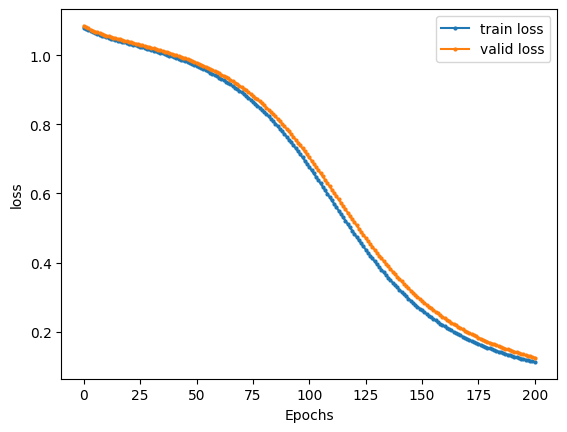

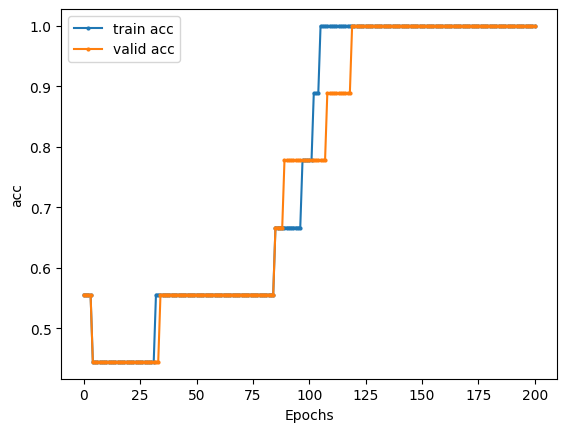

In [ ]:
# TEST Ex1.2-2
# DON'T DELETE THE OUTPUT
plot_results(res)

## Brown corpus

In this exercise we use the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) for English annotated with the [Universal POS (UPOS) tags](https://www.nltk.org/book/ch05.html#a-universal-part-of-speech-tagset). We can access the data from an NLTK's corpus list. Note that the UPOS tagset contains much fewer tags than the PennTreebank POS tags. This makes UPOS tagging relatively easy.

You are provided with a function `train_validation_split` which extracts two subsets from the given corpus. The size of the subsets can be specified in terms of the ratio to the entire corpus size.

In [ ]:
# defining the corpus view (of type ConcatenatedCorpusView), which can be iterated
BROWN_UPOS = list(nltk.corpus.brown.tagged_sents(tagset='universal'))
# Peeking inside the data
print(BROWN_UPOS[:2])

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [ ]:
# This is how to get training and validation parts of different sizes from the data
# we use seperate_tags=True to format the extracted parts according to the format of the toy datasets,
# i.e., putting tokens and their POS tags in separate lists
sample_train_data, sample_valid_data = train_validation_split(BROWN_UPOS, 0.1, 0.1, seperate_tags=True)
print(f"Training data ({len(sample_train_data)}) and validation data ({len(sample_valid_data)})")

Training data (5734) and validation data (5734)


## Ex2.3a [3pt] Train UPOS tagger

Write a code that initializes a new LSTM tagger with the **embedding dimensionality 32** and **hidden layer dimensionality 16**.
We are opting for the low-dimensional representations to keep the training time reasonable on CPUs.
Note that you will also need to create the mappings of words and tags to indices based on the **training and validation data**.
To be deterministic in creating the mappings, *sort tags and words* with `sorted` and then map sorted elements to indices. For example, this should map the token `!` and the tag `.` to 0s.
Note that the word-to-index mapping should cover all words from train and valid data, i.e. there shouldn't be unseen words in valid data.

Train the tagger on `sample_train_data` with **50 epochs** and evaluate on `sample_valid_data` using your `train_tagger` function. Save the training results in `upos_res` which will be plotted by the test cell.

In [ ]:
%%time
### YOUR CODE HERE ###

EMB_DIM = 32
HIDDEN_LAYER = 16

words = set()
tags = set()

# Collect unique words and tags from both train and valid sets

for sent, tag_seq in sample_train_data:
    words.update(sent)
    tags.update(tag_seq)
for sent, tag_seq in sample_valid_data:
    words.update(sent)
    tags.update(tag_seq)

# Create mappings using sorted order
word_to_ix = {word: idx for idx, word in enumerate(sorted(words))}
tag_to_ix = {tag: idx for idx, tag in enumerate(sorted(tags))}

# Initialize the model
brown_tagger = LSTMTagger(
    (len(word_to_ix), EMB_DIM),
    HIDDEN_LAYER,
    len(tag_to_ix)
)

# Train the model for 50 epochs
upos_res = train_tagger(
    brown_tagger,
    sample_train_data,
    word_to_ix,
    tag_to_ix,
    valid=sample_valid_data,
    epoch_num=50,
    verbose=True
)

# save results in upos_res
# should take under 20min on colab's cpu

Training: 100%|██████████| 50/50 [16:03<00:00, 19.28s/it]

CPU times: user 16min, sys: 3.29 s, total: 16min 3s
Wall time: 16min 10s


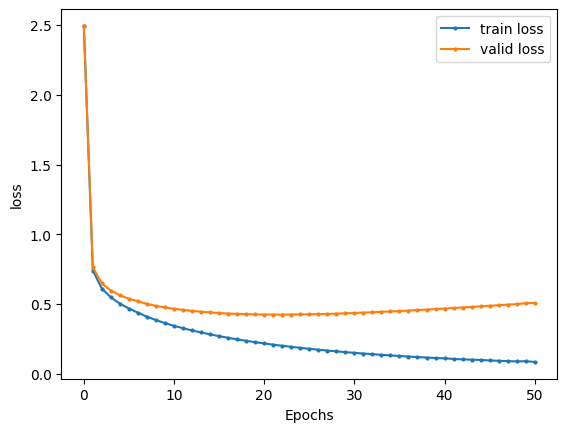

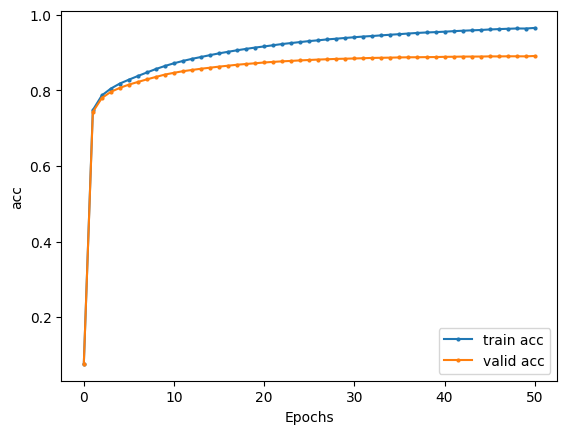

In [ ]:
# TEST Ex1.3
# DON'T DELETE THE OUTPUT
plot_results(upos_res)

## Q2.3b [2pt] Best model

Based on the training dynamics of the accuracy scores on the training and validation parts, after which epoch (if any) is recommended to stop training and why? (give the exact epoch number in your answer if it is recommended to stop training)

<font color="red">█████ ANSWER UNDER THIS LINE █████</font>

It would be raccomended to stop training the model in the 10th epoch. This is due to the fact that both accuracy dynamics, but most importantly the validation one, experience a sharp increasing in the first epoches, but then level out and stop growing around the 10th epoch. In a word, keep training after the 10th epoch entails a waste of computational effort that does not significantly affect the performance of the model in terms of accuracy (especially on the validation set).

## GloVe embeddings

In this section we are downloading the [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained static word embeddings. We will reuse it to initialize the embedding layer of an LSTM, as opposed to the random initialization we have been using so far.

In [ ]:
# downloading from the Dutch server (should be a bit faster than the original source)
GLOVE_FILE = "glove.6B.100d.txt"
!wget -nv https://naturallogic.pro/_files_/download/mNLP/{GLOVE_FILE}.bz2
!bzip2 -dk glove.6B.100d.txt.bz2

2025-05-26 16:47:59 URL:https://naturallogic.pro/_files_/download/mNLP/glove.6B.100d.txt.bz2 [107798047/107798047] -> "glove.6B.100d.txt.bz2" [1]


In [ ]:
# Course-specific package
! rm -rf assigntools
! git clone https://github.com/kovvalsky/assigntools.git
from assigntools.NLP.GloVe import GloVeEmbeddings

Cloning into 'assigntools'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 267 (delta 27), reused 6 (delta 3), pack-reused 200 (from 1)
Receiving objects: 100% (267/267), 66.36 KiB | 11.06 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
# Loading vectors from the file
glove = GloVeEmbeddings(GLOVE_FILE)
print(glove.vectors.shape)

Loading GloVe embeddings from glove.6B.100d.txt...


400000it [00:22, 17599.78it/s]


Loaded 400000 words with dimension 100
torch.Size([400000, 100])


GloVe comes with its own word-to-index mapping: `stoi` (strings to indices). You can access each word's vector as shown below.

In [ ]:
word1 = "human" #@param {type:"string"}
word2 = "robot" #@param {type:"string"}
if word1 and word2:
    tensor1 = glove.vectors[glove.stoi[word1]]
    tensor2 = glove.vectors[glove.stoi[word2]]
    sim = F.cosine_similarity(tensor1, tensor2, dim=0).item()
    print(f"similarity({word1}, {word2}) = {sim}")
elif word1:
    print(f"The index is {glove.stoi[word1]}")
    print(f"The vector is {glove.vectors[glove.stoi[word1]]}")

similarity(human, robot) = 0.34299635887145996


## Ex2.4 [11pt] Random vs GloVe

In this exercise we are comparing two LSTM-based UPOS taggers, one with randomly initialized embeddings while another reusing the GloVe embeddings.
To bolster the comparison, we will restrict the data only to those tagged sentences that consist of the words covered by the GloVe vectors (Note that GloVe covers 400K words). This also helps to reduce the data and make the experiments feasible for the colab's CPU.

Complete the designated code cell below so that it runs the following experiment:

1.   For each train & valid data split initialize two LSTM-based taggers, with the random and GloVe embeddings.
2.   Train each tagger with a predefined number of epochs. Obviously, you should reuse `train_tagger` function here.
3.   After the training is done, record the max/best score across the epochs on the validation part (because the validation score better represents the model's capacity than the training data). Use `best_valid_acc` to keep track of the best scores for each type of embedding initialization.

One important detail! This is an example of how to initialize an LSTM tagger with the GloVe word vectors that is expected to predict $N$ number of tags.
Remember, this was the reason why we modified the LSTMTagger class from the PyTorch tutorial.

```
LSTMTagger(glove.vectors, HIDDEN_DIM, N)
```

To be deterministic in creating the mappings of tags and words to indices, sort tags and words with sorted and then map sorted elements to indices. For example, this should map the token `!` and the tag `.` to 0s. Note that the word-to-index mapping should cover all words from `GLOVE_BROWN`.

In [ ]:
EMB_DIM = glove.vectors.size(1)
HID_DIM = 20
valid_ratio = 0.2
train_ratios = [0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 0.8]
epoch_num = 50
# keep the best accuracy on the valid part here. Keys
best_valid_acc = {'glove':[], 'random':[]}
# For better contrast, we are keeping only those sentences in the Brown corpus for which we have GloVe vectors
# and also keep only those sentences that have 3 and more tokens
GLOVE_BROWN = [ sent for sent in BROWN_UPOS if len(sent) > 2 and all([ w in glove.stoi for w, _ in sent ]) ]
print(f"New data size = {len(GLOVE_BROWN)}")

New data size = 1589


In [ ]:
%%time
# It should take under 20mins
### YOUR CODE HERE ###


# Looping to create the different splits
for i in range(len(train_ratios)):
  brown_train_data, brown_valid_data = train_validation_split(GLOVE_BROWN, train_ratios[i], valid_ratio, seperate_tags = True)


# Create a deterministic mapping as before
  word_vocab = set()
  tag_list = set()

  for sent, tag_seq in brown_train_data:
      word_vocab.update(sent)
      tag_list.update(tag_seq)
  for sent, tag_seq in brown_valid_data:
      word_vocab.update(sent)
      tag_list.update(tag_seq)

  word_to_i = {word: idx for idx, word in enumerate(sorted(word_vocab))}
  tag_to_i = {tag: idx for idx, tag in enumerate(sorted(tag_list))}

# Initializing the model with random embeddings
  random_brown_tagger = LSTMTagger((len(word_to_i), EMB_DIM),
                                 HID_DIM,
                                 len(tag_to_i))

# Create a matrix to store the glove embeddings
  emb_matrix = torch.zeros(len(word_to_i), EMB_DIM)

  for word, idx in word_to_i.items():
    glove_idx = glove.stoi[word]
    emb_matrix[idx] = glove.vectors[glove_idx]

# Initializing the model with glove embeddings
  glove_brown_tagger = LSTMTagger(
      emb_matrix,
      HID_DIM,
      len(tag_to_i)
  )

# Train the two different models
  random_res = train_tagger(
      random_brown_tagger,
      brown_train_data,
      word_to_i,
      tag_to_i,
      valid=brown_valid_data,
      epoch_num=50,
      verbose=True)

  glove_res = train_tagger(
      glove_brown_tagger,
      brown_train_data,
      word_to_i,
      tag_to_i,
      valid=brown_valid_data,
      epoch_num=50,
      verbose=True)

# Store the best_acc in the dictionary
  best_valid_acc['random'].append(random_res['valid']['best_acc'])
  best_valid_acc['glove'].append( glove_res['valid']['best_acc'] )

Training: 100%|██████████| 50/50 [02:17<00:00,  2.75s/it]

CPU times: user 11min 26s, sys: 2.29 s, total: 11min 29s
Wall time: 11min 33s


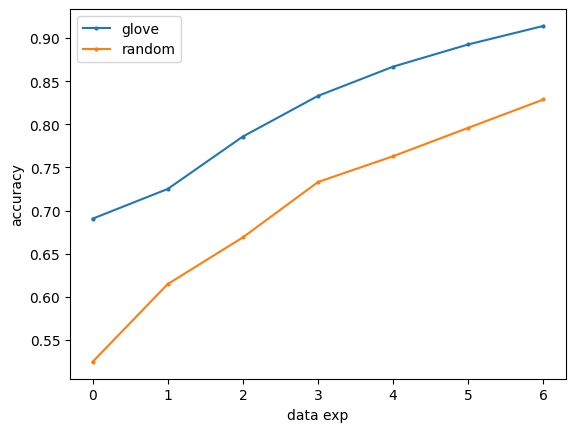

In [ ]:
# TEST 1.4
# DON'T DELETE THE OUTPUT
plot_numbers(best_valid_acc['glove'], label='glove', ylabel='accuracy', xlabel='data exp')
plot_numbers(best_valid_acc['random'], label='random', ylabel='accuracy', xlabel='data exp')

Based on the plots of the best accuracy scores on the validation part, how would you compare the use of randomized embeddings to the use of pre-trained embeddings?

<font color="red">█████ ANSWER UNDER THIS LINE █████</font>

When using a smaller training set (so in particular in the first splits represented in the plot), there is a sharp difference in the accuracy between the two different methods of embeddings. In fact, the pre-trained embeddings perform considerably better compared to the randomly initialized ones. However, this discrepancy between the two accuracy performances becomes less significative as the training set gets progressively bigger (especially in the last splits of the graph above).

## Work description for Ex2

~~Describe your approach to solving the exercises, for example, what steps you took first, followed by subsequent actions, which parts you found most challenging or easy, any specific helpful assistance received from TAs, whether you used GenAI, to what extent, at what stage, which one, how helpful was it, etc.~~

YOUR ANSWER HERE [100-200 words]

We started by carefully going trhough the slides on RNNs models for NLP (in particular LSTM). We also dedicated some time to carefully read the tutorial as suggested by the guidelines. When coding, we initially tried to set the main structure of the code, and then implemented each subsection seperately. As an example, for exercise 2.1a: prepare the input for the the model, then apply the model to the data, and ultimately compute and store the required metrics.

We struggled the most with exercises 2.1a and 2.2, which required a lot of effort to structure the code properly and implement some of the subsections. After writing the code for these two exercises, GenAI (in particular chatGPT) helped us to spot eventual shortcomings and gave suggestions to fix bugs. Also the TA gave us some important tips. As regards the other exercises, GenAI was used to a less extent, only to review.



# Acknowledgments

Most of the part 1 was developed in collaboration with Joost Bastings.  
Later it was revised by Tejaswini Deoskar.  
The recent updates by Lasha Abzianidze make the notebook more streamlined and foolproof from the grading and the large course perspectives.

The initial version of part 2, by Denis Paperno, included the contrast of pretrained and random word embeddings on POS tagging (using the extended Penn Treebank POS tags). The assignment was built around the allennlp library.

Since 2022-23 course, the assignment was substantially changed by Lasha Abzianidze. allennlp was replaced with pytorch and transformers library. Penn Treebank POS tagging was replaced with Universal POS tagging. Part 2 now teaches students how to build a neural network tagger instead of using out-of-the-box tagger. These changes also drastically decreased GPU/CPU processing time.